In [22]:
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Categorical
import numpy as np
import os
import copy
import gym
from gym.wrappers import RescaleAction
import random
from torch.utils.tensorboard import SummaryWriter

from icsl_rl.utils import _read_yaml

from icsl_rl.agent import DQNAgent, DoubleDQNAgent, DuelingDQNAgent, D3QNAgent, NoisyDQNAgent
from icsl_rl.agent import DDPGAgent, TD3Agent, SACAgent, PPOAgent, A2CAgent, BC_SACAgent
from icsl_rl.runner import Runner

In [23]:
parameter_patgh = './icsl_rl/Hyperparameter/dqn.yaml'   # Algorithms can be chosen by themselves
config = _read_yaml(parameter_patgh)
print(config)

{'algorithm': 'DQN', 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.01, 'hidden_size': 128, 'update_rate': 100, 'buffer_size': 1000, 'batch_size': 32, 'epsilon': 1.0, 'min_epsilon': 0.1, 'epsilon_decay': 0.0005, 'use_epsilon': True, 'is_discrete': True, 'use_noisy_layer': False, 'is_off_policy': True}


In [24]:
import argparse
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
# In the jupyter book, the argparse library is not easy to use, so use the following form instead
args = argparse.Namespace(algorithm='DQN', device=device, evaluate=False)
print(args)

args.__dict__ = config
print(args)

args.device = device                # GPU or CPU
args.seed = 123                     # random seed setting
args.render = False                 # Visualization during training.
args.time_steps = 3000000           # total training step
args.episode = 1000000              # total episode
args.save_dir = "./model"           # Where to store the trained model
args.save_rate = 2000               # store rate
args.model_dir = ""                 # Where to store the trained model
args.evaluate_episodes = 10         # Parameters for Model Prediction
args.evaluate = False                # Parameters for Model Prediction
args.evaluate_rate = 1000           # Parameters for Model Prediction
args.is_store_transition = False    # Store expert data
args.env_name = 'CartPole-v0'          # discrete env
print(args)

Namespace(algorithm='DQN', device=device(type='cuda', index=0), evaluate=False)
Namespace(algorithm='DQN', batch_size=32, buffer_size=1000, critic_lr=0.001, epsilon=1.0, epsilon_decay=0.0005, gamma=0.99, hidden_size=128, is_discrete=True, is_off_policy=True, min_epsilon=0.1, tau=0.01, update_rate=100, use_epsilon=True, use_noisy_layer=False)
Namespace(algorithm='DQN', batch_size=32, buffer_size=1000, critic_lr=0.001, device=device(type='cuda', index=0), env_name='CartPole-v0', episode=1000000, epsilon=1.0, epsilon_decay=0.0005, evaluate=False, evaluate_episodes=10, evaluate_rate=1000, gamma=0.99, hidden_size=128, is_discrete=True, is_off_policy=True, is_store_transition=False, min_epsilon=0.1, model_dir='', render=False, save_dir='./model', save_rate=2000, seed=123, tau=0.01, time_steps=3000000, update_rate=100, use_epsilon=True, use_noisy_layer=False)


In [25]:
def _random_seed(seed):      # random seed setting
    if T.backends.cudnn.enabled:
        T.backends.cudnn.benchmark = False
        T.backends.cudnn.deterministic = True

    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('Using GPU : ', T.cuda.is_available() , ' |  Seed : ', seed)

In [26]:
_random_seed(args.seed)

Using GPU :  True  |  Seed :  123


In [27]:
writer = SummaryWriter('./logs/' + args.algorithm)           # Tensorboard

In [32]:
agent = DQNAgent(args)            # agent setting
runner = Runner(agent, args, agent.env, writer)

In [33]:
runner.run()                  # Training

 : 38 | Score : 136.0 | Avg score : 130.6 | Time_Step : 2137 |  update number : 2106 |
------ Save model ------
Episode : 39 | Score : 163.0 | Avg score : 140.5 | Time_Step : 2300 |  update number : 2269 |
------ Save model ------
Episode : 40 | Score : 170.0 | Avg score : 146.8 | Time_Step : 2470 |  update number : 2439 |
------ Save model ------
Episode : 41 | Score : 190.0 | Avg score : 148.2 | Time_Step : 2660 |  update number : 2629 |
------ Save model ------
Episode : 42 | Score : 200.0 | Avg score : 154.8 | Time_Step : 2860 |  update number : 2829 |
| Episode : 43 | Score : 140.0 | Predict Score : 197.5 | Avg score : 154.8 |
------ Save model ------
Episode : 43 | Score : 141.0 | Avg score : 157.4 | Time_Step : 3001 |  update number : 2970 |
------ Save model ------
Episode : 44 | Score : 200.0 | Avg score : 163.2 | Time_Step : 3201 |  update number : 3170 |
Episode : 45 | Score : 187.0 | Avg score : 163.2 | Time_Step : 3388 |  update number : 3357 |
------ Save model ------
Epi

In [35]:
returns = runner.evaluate()               # Test
print(returns)

200.0


In [45]:
dqn_total_path = './model/DQN/CartPole-v0/episode_return.txt'
dqn_step_path = './model/DQN/CartPole-v0/step_return.txt'
dqn_total =  np.loadtxt(dqn_total_path, delimiter=',')
dqn_step =  np.loadtxt(dqn_step_path, delimiter=',')

In [46]:
def var_name(var,all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

In [53]:
import matplotlib.pyplot as plt
import os
import numpy as np
def _step_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Step Reward")
    plt.grid(True)

    name = var_name(scores).replace('_step', '')

    plt.xlabel("step * 1000")
    plt.ylabel("Average Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

def _avg_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Reward")
    plt.grid(True)

    name = var_name(scores).replace('_total', '')

    z = [c+1 for c in range(len(scores))]
    running_avg = np.zeros(len(scores))
    for e in range(len(running_avg)):
        running_avg[e] = np.mean(scores[max(0, e-10):(e+1)])

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.plot(z, running_avg, "b-", linewidth=1.5, label= name + "_avg_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

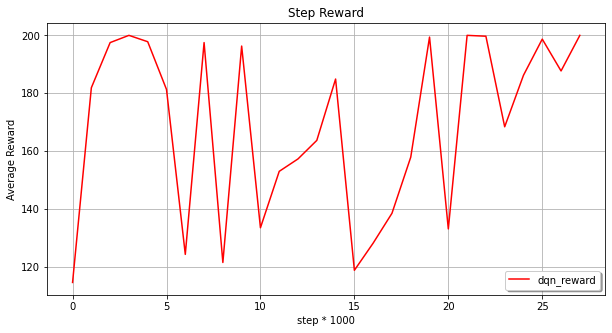

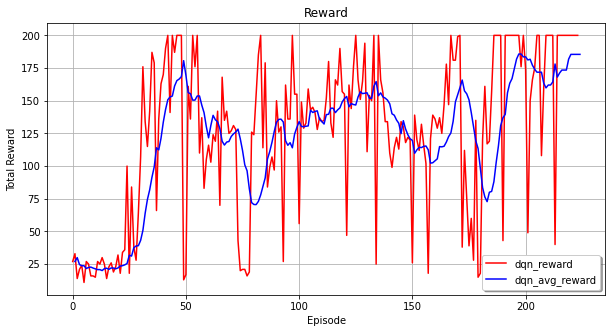

In [54]:
_step_plot(dqn_step)
_avg_plot(dqn_total)